In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal, interpolate
import pandas as pd

import h5py

# Set font size for plots
matplotlib.rcParams['font.size'] = 8

# Create time vector

cm = 1/2.54  # cm to inches


# Load data from csv using numpy
# Load data from CSV using pandas, ensuring 'field' is read as string
pump_df = pd.read_csv('FilteredWaveformSCG0403.csv', delimiter=',', dtype={'field': float})

# # Funktion zum Parsen von komplexen Zahlen aus Strings 
# def parse_complex(s):
#     s = s.replace('im', 'j')  # Ersetze 'im' durch 'j'
#     s = s.replace(' ', '')      # Entferne Leerzeichen
#     return complex(s)

# # Konvertiere die 'field'-Spalte in komplexe Zahlen
# pump_df['field'] = pump_df['field'].apply(parse_complex)

# Optional: Konvertiere das DataFrame in ein numpy-Array, falls benötigt
pump = pump_df.to_numpy()

pumpField = pump[:,1]

referencePulse = np.loadtxt('ReferencePulse.csv', delimiter=',',skiprows=1)

refField = referencePulse[:,1]

Sampled = np.loadtxt('SampledArtificialWaveformHighResShortGatePi.csv', delimiter=',',skiprows=1)

convolutedSignal = Sampled[:,1]


t = Sampled[:,0]

tPump =pump[:,0].astype(float)



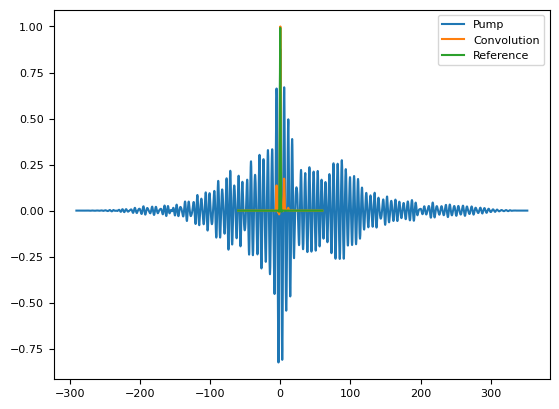

In [2]:
plt.plot(tPump,pumpField,label='Pump')
plt.plot(t,convolutedSignal,label='Convolution')
plt.plot(t,refField,label='Reference')
plt.legend()

(1e-08, 1000.0)

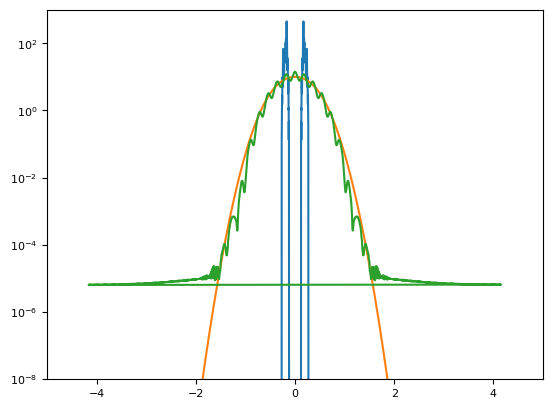

In [3]:
# Plot spectral domain of signals
freq = np.fft.fftfreq(len(t), t[1] - t[0])
pumpFreq = np.fft.fftfreq(len(tPump), tPump[1] - tPump[0])

pumpField_f = np.fft.fft(pumpField)
refField_f = np.fft.fft(refField)
convolutedSignal_f = np.fft.fft(convolutedSignal)


plt.figure()
plt.semilogy(pumpFreq, np.abs(pumpField_f), label='Pump')
plt.semilogy(freq, np.abs(refField_f), label='Reference')
plt.semilogy(freq, np.abs(convolutedSignal_f), label='Convolution')
plt.xlim(-5,5)
plt.ylim(1e-8,1e3)


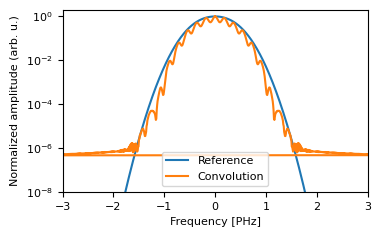

In [73]:

plt.figure(figsize=(cm*10, cm*6))
plt.semilogy(freq, np.abs(refField_f)/np.max(np.abs(refField_f)), label='Reference')
plt.semilogy(freq, np.abs(convolutedSignal_f)/np.max(np.abs(convolutedSignal_f)), label='Convolution')
plt.xlim(-3,3)
plt.xlabel('Frequency [PHz]')
plt.ylim(1e-8,2e0)
plt.ylabel('Normalized amplitude (arb. u.)')
plt.legend()


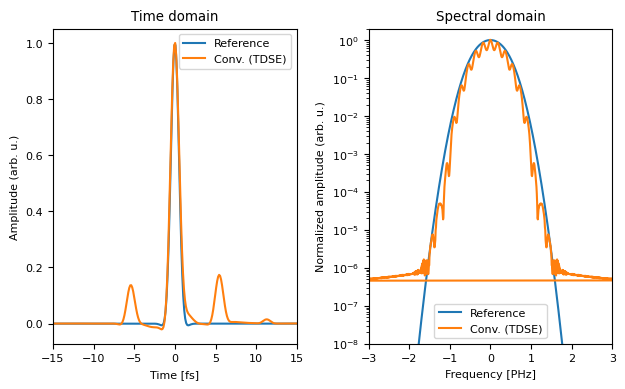

In [ ]:
# Make two panel plot
fig, [ax,ax2] = plt.subplots(1, 2, figsize=(cm*16, cm*10))
ax.plot(t,refField,label='Reference')
ax.plot(t-0.15,convolutedSignal,label='Conv. (TDSE)')
ax.set_xlim(-15,15)
ax.set_xlabel('Time [fs]')
ax.set_ylabel('Amplitude (arb. u.)')
ax.legend()
ax.title.set_text('Time domain')

ax2.semilogy(freq, np.abs(refField_f)/np.max(np.abs(refField_f)), label='Reference')
ax2.semilogy(freq, np.abs(convolutedSignal_f)/np.max(np.abs(convolutedSignal_f)), label='Conv. (TDSE)')
ax2.set_xlim(-3,3)
ax2.set_xlabel('Frequency [PHz]')
ax2.set_ylim(1e-8,2e0)
ax2.set_ylabel('Normalized amplitude (arb. u.)')
ax2.legend()
ax2.title.set_text('Spectral domain')
fig.tight_layout()
fig.savefig('convolution.png', dpi=600)

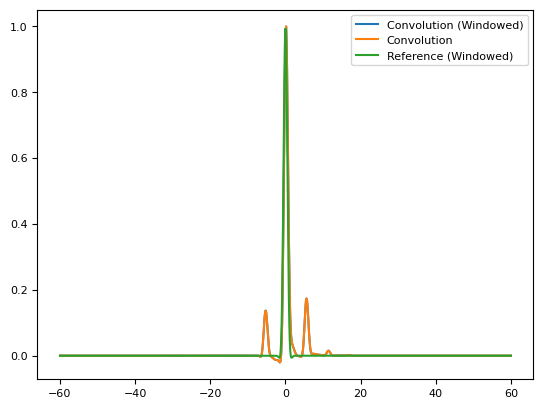

In [4]:
# Optional: Apply a window function to reduce edge effects
window = signal.windows.tukey(len(t),alpha=0.3)
convoluted_signal_windowed = convolutedSignal * window
refField_windowed = refField * window

plt.figure()
plt.plot(t, convoluted_signal_windowed, label='Convolution (Windowed)')
plt.plot(t, convolutedSignal, label='Convolution')
plt.plot(t, refField_windowed, label='Reference (Windowed)')

plt.legend()


In [5]:
pumpField[1]

2.147961288659417e-05

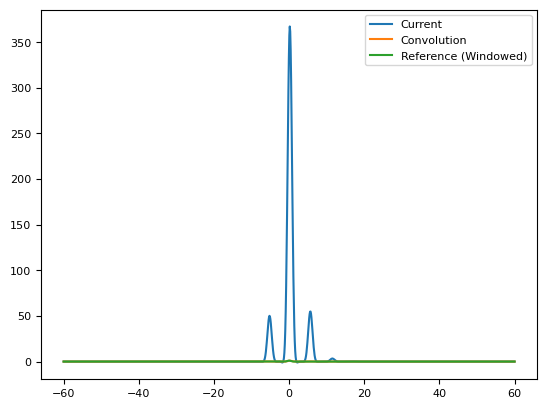

In [6]:


def FNemission(inField, criticalField, fieldEnhancement):
    """
    Calculate the emission field based on the input field, critical field, and field enhancement factor.
    Parameters:
    inField (numpy.ndarray): The input field, which is a complex array.
    criticalField (float): The critical field value.
    fieldEnhancement (float): The field enhancement factor.
    Returns:
    numpy.ndarray: The calculated emission field.
    """
    real_inField = np.real(inField).astype(float)
    
    out = np.heaviside(real_inField, 1) * (real_inField * fieldEnhancement) ** 2 * np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))
    
    return out

# def FNemissionDerivative(inField, criticalField, fieldEnhancement):
#     real_inField = np.real(inField).astype(float)
    
#     heaviside_vals = np.heaviside(real_inField, 1)
#     exp_term = np.exp(-criticalField / np.abs(fieldEnhancement * real_inField))
#     term1 = real_inField * fieldEnhancement ** 2 * exp_term
#     term2 = fieldEnhancement ** 2 * criticalField * exp_term
#     derCurrent = -heaviside_vals * 2 * (term1 - term2)
#     return derCurrent


def FNemissionDerivative(inField, criticalField, fieldEnhancement):
    real_inField = np.real(inField).astype(float)
    derCurrent = np.heaviside(real_inField, 1) *np.exp(-criticalField / np.abs(fieldEnhancement * real_inField)) *(criticalField + 2 * fieldEnhancement * real_inField)
    return derCurrent



# Calculating the cross correlation using fowler nordheim function

# interpolating the reference signal to the same time points as the convolution signal
f = interpolate.interp1d(t, refField, kind='linear', fill_value='extrapolate')

current = np.zeros_like(t)

for i,value in enumerate(t):
    current[i] = np.sum(FNemission( pumpField + (1/3300)* f(tPump-t[i]),76,15)) *(tPump[1]-tPump[0])

current -= current[0]

current = -current/np.max(current)
dt = t[1] - t[0]
plt.figure()
plt.plot(t, current , label='Current')
plt.plot(t, convolutedSignal, label='Convolution')
plt.plot(t, refField_windowed, label='Reference (Windowed)')
plt.legend()

(-15.0, 15.0)

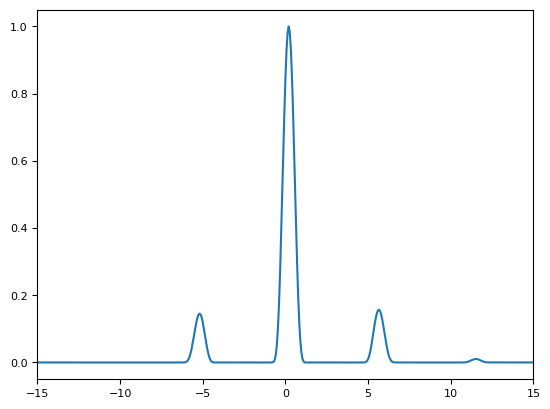

In [7]:
plt.plot(tPump, FNemissionDerivative(pumpField,76,15)/np.max(FNemissionDerivative(pumpField,76,15)), label='Type1')
plt.xlim(-15,15)

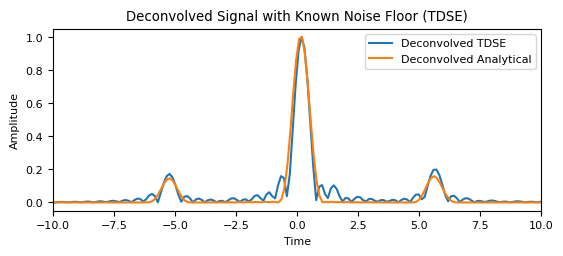

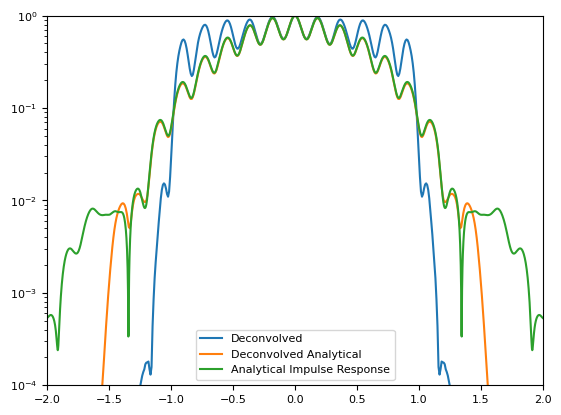

In [134]:
window = signal.windows.tukey(len(t),alpha=0.3)

convoluted_signal_windowed = convolutedSignal * window
refField_windowed = refField * window

# Compute the FFTs
fft_convoluted = np.fft.fft(convoluted_signal_windowed)
fft_convolutedAnalytical = np.fft.fft(current)

fft_refField = np.fft.fft(refField_windowed)


# Compute the conjugate of the reference field FFT
H_conj = np.conj(refField_f)

# Compute the power spectral density of the reference field
S_xx = np.abs(refField_f) ** 2

SNR = 0.8e-4
SNRanalytical = 1e-8

# Compute the Wiener filter using the known noise power spectrum
wiener_filter = H_conj / np.sqrt((S_xx)** 2 + SNR)

wiener_filterAnalytical = H_conj / (S_xx + SNRanalytical)

AlternateFilter =(1 / refField_f) * np.abs(refField_f) ** 2 / (np.abs(refField_f) ** 2 + SNR**2)


# Apply the Wiener filter
fft_deconvolved = fft_convoluted * wiener_filter
fft_deconvolvedAnalytical = fft_convolutedAnalytical * wiener_filterAnalytical

# Compute the inverse FFT to get the deconvolved signal
deconvolved_signal = np.fft.ifft(fft_deconvolved)
deconvolved_signalAnalytical = np.fft.ifft(fft_deconvolvedAnalytical)

# Take the real part of the signal
deconvolved_signal_real = np.abs(deconvolved_signal)
deconvolved_signalAnalytical_real = np.abs(deconvolved_signalAnalytical)

deconvolved_signal_real2 = np.fft.ifftshift(deconvolved_signal_real)
deconvolved_signalAnalytical_real2 = np.fft.ifftshift(deconvolved_signalAnalytical_real)

plt.figure(figsize=(cm*16, cm*6))
plt.plot(t, deconvolved_signal_real2/np.max(deconvolved_signal_real2), label='Deconvolved TDSE')
plt.plot(t-0.1, deconvolved_signalAnalytical_real2/np.max(deconvolved_signalAnalytical_real2), label='Deconvolved Analytical')
plt.xlabel('Time')
plt.xlim(-10, 10)
plt.ylabel('Amplitude')
plt.title('Deconvolved Signal with Known Noise Floor (TDSE)')
plt.legend()
plt.show()

#spectrum analytical impulse response 
specAnalytical = np.fft.fft(FNemissionDerivative(pumpField, 76, 15)/np.max(FNemissionDerivative(pumpField, 76, 15)))
freqPump = np.fft.fftfreq(len(tPump), tPump[1] - tPump[0])

plt.semilogy(freq,np.abs(fft_deconvolved)/np.max(np.abs(fft_deconvolved)),label='Deconvolved')
plt.semilogy(freq,np.abs(fft_deconvolvedAnalytical)/np.max(np.abs(fft_deconvolvedAnalytical)),label='Deconvolved Analytical')
plt.semilogy(freqPump,np.abs(specAnalytical)/np.max(np.abs(specAnalytical)),label='Analytical Impulse Response')
plt.xlim(-2,2)
plt.ylim(1e-4,1)
plt.legend()
plt.show()

# saving both in csv files
np.savetxt('DeconvolvedSignalTDSEShortGate.csv', np.column_stack((t, deconvolved_signal_real2)), delimiter=',', header='Time,Amplitude', comments='')
np.savetxt('DeconvolvedSignalAnalyticalShortGate.csv', np.column_stack((t, deconvolved_signalAnalytical_real2)), delimiter=',', header='Time,Amplitude', comments='')



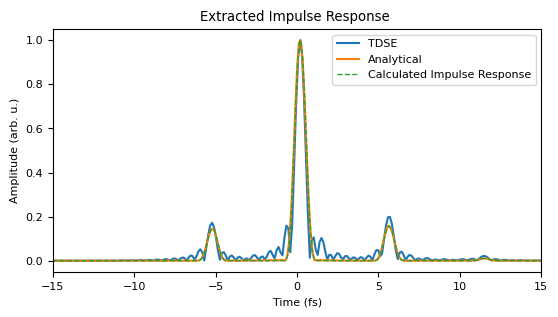

In [116]:
deconvolved_signal_real2 = np.fft.ifftshift(deconvolved_signal_real)

plt.figure(figsize=(cm*16, cm*8))

plt.plot(t, deconvolved_signal_real2/np.max(deconvolved_signal_real2), label='TDSE')
plt.plot(t-0.07, deconvolved_signalAnalytical_real2/np.max(deconvolved_signalAnalytical_real2), label='Analytical')
plt.plot(tPump,FNemissionDerivative(pumpField, 76, 15)/np.max(FNemissionDerivative(pumpField, 76, 15)),linestyle="--",label='Calculated Impulse Response',linewidth=1)

plt.xlabel('Time (fs)')
plt.xlim(-15,15)
plt.ylabel('Amplitude (arb. u.)')
plt.title('Extracted Impulse Response ')
plt.legend(loc='upper right')
plt.savefig('ImpulseResponseWiener.pdf', dpi=600)
plt.show()

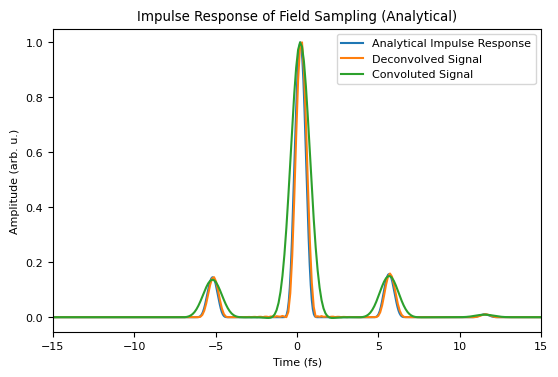

In [105]:

plt.figure(figsize=(cm*16, cm*10))

plt.plot(tPump,FNemissionDerivative(pumpField, 76, 15)/np.max(FNemissionDerivative(pumpField, 76, 15)),label='Analytical Impulse Response')
plt.plot(t, deconvolved_signalAnalytical_real2/np.max(deconvolved_signalAnalytical_real2), label='Deconvolved Signal')
plt.plot(t,current/np.max(current),label='Convoluted Signal')
plt.xlabel('Time (fs)')
plt.xlim(-15,15)
plt.ylabel('Amplitude (arb. u.)')
plt.title('Impulse Response of Field Sampling (Analytical)')
plt.legend(loc='upper right')
plt.savefig('ImpulseResponseAnalytical.png', dpi=600)
plt.show()

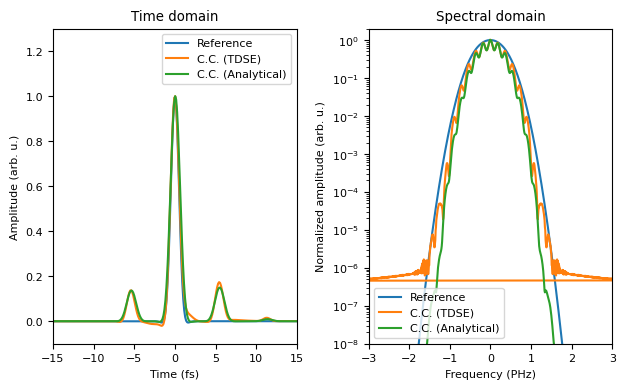

In [117]:
# Make two panel plot
fig, [ax,ax2] = plt.subplots(1, 2, figsize=(cm*16, cm*10))
ax.plot(t,refField,label='Reference')
ax.plot(t-0.15,convolutedSignal,label='C.C. (TDSE)')
ax.plot(t-0.15,current/np.max(current),label='C.C. (Analytical)')
ax.set_xlim(-15,15)
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Amplitude (arb. u.)')
ax.set_ylim(-0.1,1.3)
ax.legend(loc='upper right')
ax.title.set_text('Time domain')

ax2.semilogy(freq, np.abs(refField_f)/np.max(np.abs(refField_f)), label='Reference')
ax2.semilogy(freq, np.abs(convolutedSignal_f)/np.max(np.abs(convolutedSignal_f)), label='C.C. (TDSE)')
ax2.semilogy(freq, np.abs(fft_convolutedAnalytical)/np.max(np.abs(fft_convolutedAnalytical)), label='C.C. (Analytical)')
ax2.set_xlim(-3,3)
ax2.set_xlabel('Frequency (PHz)')
ax2.set_ylim(1e-8,2e0)
ax2.set_ylabel('Normalized amplitude (arb. u.)')
ax2.legend()
ax2.title.set_text('Spectral domain')
fig.tight_layout()
fig.savefig('Convolution.pdf', dpi=600)